In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='white')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and direc

In [2]:
# 1. Java 및 konlpy 설치
!apt-get update
!apt-get install -y openjdk-11-jdk
!pip install konlpy JPype1==1.4.1

# 2. JAVA_HOME 환경변수 설정
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,249 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,986 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/

In [3]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt

df = pd.read_csv("merged_reviews_by_professor.csv")

In [4]:
# 교수별 리뷰 통합
grouped = df.groupby("professor")["review"].apply(lambda x: " ".join(x.dropna().astype(str))).reset_index()
grouped["review"] = grouped["review"].str.replace(r'\n', ' ', regex=True)

def clean_text(text):
    import re
    text = re.sub(r"[^\uAC00-\uD7A3\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

grouped["review"] = grouped["review"].apply(clean_text)

# 형태소 분석기 초기화
okt = Okt()

# 긍정 키워드 목록 정의
positive_keywords = { "좋다", "재밌다", "이해", "열정", "설명", "쉽다", "유익", "깔끔", "명확", "친절", "유쾌", "잘하다", "유능", "성실", "체계", "전문", "성의", "배려", "공감", "도움", "흥미" }

In [5]:
# 키워드 추출 및 긍정 단어 수 계산 함수 정의
def extract_keywords(text):
    words = okt.pos(text, stem=True)
    return [word for word, tag in words if tag in ["Noun", "Adjective", "Verb"]]

def count_positive(words):
    return sum(1 for word in words if word in positive_keywords)

# 키워드 추출
grouped["keywords"] = grouped["review"].apply(extract_keywords)

# 전체 키워드 빈도 계산
all_keywords = grouped["keywords"].sum()
all_counter = Counter(all_keywords)

# 교수별 고유한 대표 키워드 추출 함수 (희소성 고려)
def get_top_keywords_unique(word_list):
    filtered = [w for w in word_list if w in positive_keywords]
    counter = Counter(filtered)
    # 희소성 점수: 해당 교수의 빈도 / 전체 리뷰에 등장한 빈도
    score_list = [(kw, freq / all_counter[kw]) for kw, freq in counter.items()]
    score_list.sort(key=lambda x: (-x[1], -counter[x[0]]))  # 희소성 > 빈도 기준 정렬
    return ", ".join([kw for kw, _ in score_list[:3]])

In [6]:
# 분석 및 점수 계산
grouped["positive_score"] = grouped["keywords"].apply(count_positive)
grouped["review_count"] = grouped["keywords"].apply(len)
grouped["popularity_score"] = grouped["positive_score"] + grouped["review_count"].apply(lambda x: 0.1 * x)
grouped["top_keywords"] = grouped["keywords"].apply(get_top_keywords_unique)

# 상위 5명 추출 및 컬럼명 한글로 변경
top5 = grouped.sort_values("popularity_score", ascending=False).head(5)
top5 = top5[["professor", "positive_score", "review_count", "popularity_score", "top_keywords"]]
top5.columns = ["교수 이름", "긍정 키워드 수", "총 리뷰 단어 수", "인기 점수", "대표 키워드"]

In [8]:
grouped

,professor,review,keywords,positive_score,review_count,popularity_score,top_keywords
0,김선정,친근하다적극적이다좋다 매 수업마다 파일을 올려주시며 그 에 나온 대로 따라만 하면 ...,"[친근하다, 적극, 좋다, 매, 수업, 파일, 올려주다, 그, 나오다, 대로, 따르...",119,3469,465.9,"이해, 쉽다, 배려"
1,김유섭,친근하다적극적이다좋다 교수님의 말투가 친근하고 또박또박 말씀하셔서 듣기가 좋습니다 ...,"[친근하다, 적극, 좋다, 교수, 말투, 친근하다, 또박또박, 말씀, 하다, 듣기,...",142,3810,523.0,"좋다, 도움, 이해"
2,김은주,친근하다적극적이다좋다 딕션이 좋으시고 말이 굉장히 빠르시다 말이 빠르셔서 그냥 귀에...,"[친근하다, 적극, 좋다, 딕션, 좋다, 말, 굉장하다, 빠르다, 말, 빠르다, 그...",286,6590,945.0,"열정, 체계, 도움"
3,신미영,친근하다적극적이다좋다 강의 자료가 좋아서 교수님중에서 가장 배워갈께 많은 교수님인것...,"[친근하다, 적극, 좋다, 강의, 자료, 좋다, 교수, 중, 가장, 배우다, 갈다,...",247,6587,905.7,"성의, 흥미, 도움"
4,양은샘,친근하다적극적이다좋다 과제가 좀 많은게 단점이지만 그만큼 배워 갈수있는것도 많은 교...,"[친근하다, 적극, 좋다, 과제, 좀, 많다, 단점, 배우다, 갈수, 있다, 많다,...",305,6104,915.4,"배려, 설명, 재밌다"
5,이정근,친근하다적극적이다좋다 이정근 교수님은 굉장히 친절하십니다 강의자료가 영어로 되어있고...,"[친근하다, 적극, 좋다, 이정근, 교수, 굉장하다, 친절하다, 강의, 자료, 영어...",85,1443,229.3,"쉽다, 배려, 체계"


In [7]:
# 블록 형태 출력
print("📢 추천 교수 TOP 5:\n")
for i, row in top5.iterrows():
    print(f"---------- TOP {top5.index.get_loc(i)+1} ----------")
    print(f"교수 이름: {row['교수 이름']}")
    print(f"긍정 키워드 수: {row['긍정 키워드 수']}")
    print(f"총 리뷰 단어 수: {row['총 리뷰 단어 수']}")
    print(f"인기 점수: {row['인기 점수']:.1f}")
    print(f"대표 키워드: {row['대표 키워드']}")
    print()

📢 추천 교수 TOP 5:

---------- TOP 1 ----------
교수 이름: 김은주
긍정 키워드 수: 286
총 리뷰 단어 수: 6590
인기 점수: 945.0
대표 키워드: 열정, 체계, 도움

---------- TOP 2 ----------
교수 이름: 양은샘
긍정 키워드 수: 305
총 리뷰 단어 수: 6104
인기 점수: 915.4
대표 키워드: 배려, 설명, 재밌다

---------- TOP 3 ----------
교수 이름: 신미영
긍정 키워드 수: 247
총 리뷰 단어 수: 6587
인기 점수: 905.7
대표 키워드: 성의, 흥미, 도움

---------- TOP 4 ----------
교수 이름: 김유섭
긍정 키워드 수: 142
총 리뷰 단어 수: 3810
인기 점수: 523.0
대표 키워드: 좋다, 도움, 이해

---------- TOP 5 ----------
교수 이름: 김선정
긍정 키워드 수: 119
총 리뷰 단어 수: 3469
인기 점수: 465.9
대표 키워드: 이해, 쉽다, 배려



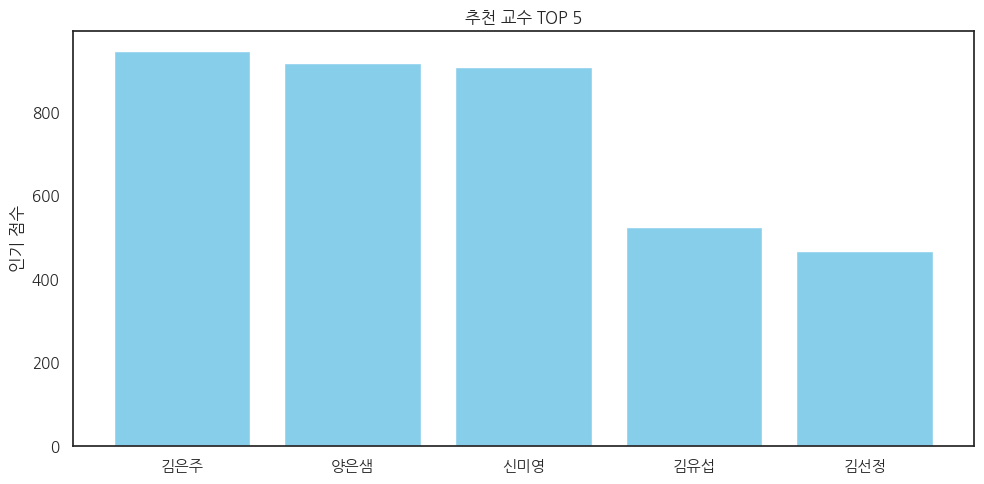

In [ ]:
# 시각화
plt.figure(figsize=(10, 5))
plt.bar(top5["교수 이름"], top5["인기 점수"], color="skyblue")
plt.title("추천 교수 TOP 5")
plt.ylabel("인기 점수")
plt.tight_layout()
plt.show()

In [11]:
# 'grouped'에 이미 계산된 컬럼들이 있다고 가정합니다.
# 인기 점수(popularity_score) 기준으로 내림차순 정렬
ranked = grouped.sort_values("popularity_score", ascending=False).reset_index(drop=True)

print("📢 추천 교수 순위:\n")
for idx, row in ranked.iterrows():
    print(f"---------- TOP {idx+1} ----------")
    print(f"교수 이름       : {row['professor']}")
    print(f"긍정 키워드 수 : {row['positive_score']}")
    print(f"총 리뷰 단어 수: {row['review_count']}")
    print(f"인기 점수      : {row['popularity_score']:.1f}")
    print(f"대표 키워드    : {row['top_keywords']}")
    print()


📢 추천 교수 순위:

---------- TOP 1 ----------
교수 이름       : 김은주
긍정 키워드 수 : 286
총 리뷰 단어 수: 6590
인기 점수      : 945.0
대표 키워드    : 열정, 체계, 도움

---------- TOP 2 ----------
교수 이름       : 양은샘
긍정 키워드 수 : 305
총 리뷰 단어 수: 6104
인기 점수      : 915.4
대표 키워드    : 배려, 설명, 재밌다

---------- TOP 3 ----------
교수 이름       : 신미영
긍정 키워드 수 : 247
총 리뷰 단어 수: 6587
인기 점수      : 905.7
대표 키워드    : 성의, 흥미, 도움

---------- TOP 4 ----------
교수 이름       : 김유섭
긍정 키워드 수 : 142
총 리뷰 단어 수: 3810
인기 점수      : 523.0
대표 키워드    : 좋다, 도움, 이해

---------- TOP 5 ----------
교수 이름       : 김선정
긍정 키워드 수 : 119
총 리뷰 단어 수: 3469
인기 점수      : 465.9
대표 키워드    : 이해, 쉽다, 배려

---------- TOP 6 ----------
교수 이름       : 이정근
긍정 키워드 수 : 85
총 리뷰 단어 수: 1443
인기 점수      : 229.3
대표 키워드    : 쉽다, 배려, 체계



In [12]:
# 1. 인기 점수 순으로 정렬한 DataFrame 준비
ranked = grouped.sort_values("popularity_score", ascending=False).reset_index(drop=True)

# 2. 출력용 컬럼만 뽑고, 한글 컬럼명으로 변경
output = ranked[[
    "professor",       # 교수 내부 이름
    "positive_score",  # 긍정 키워드 수
    "review_count",    # 총 리뷰(토큰) 수
    "popularity_score",
    "top_keywords"
]].copy()
output.columns = [
    "교수 이름",
    "긍정 키워드 수",
    "총 리뷰 단어 수",
    "인기 점수",
    "대표 키워드"
]

# 3. CSV로 저장 (utf-8-sig로 인코딩하면 Excel에서 한글 깨짐 방지)
output.to_csv("professor_recommendations.csv", index=False, encoding="utf-8-sig")

print("✅ professor_recommendations.csv 파일이 생성되었습니다.")


✅ professor_recommendations.csv 파일이 생성되었습니다.
